Figure saved as repertoire_capture_vs_subset_size.png


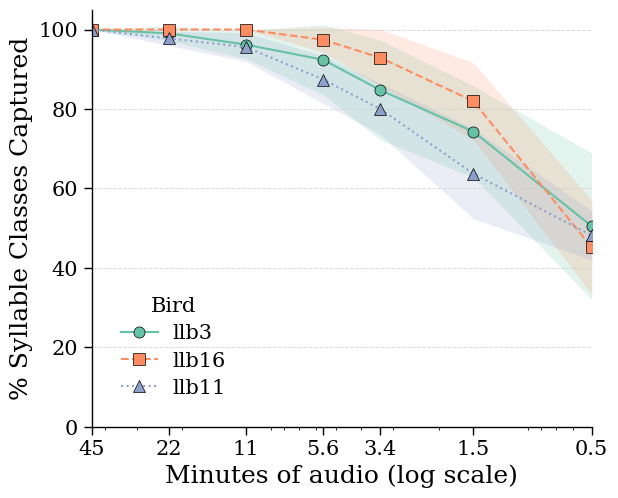

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_repertoire_capture_vs_subset_size():
    """
    For each bird, computes the mean and std of the percentage of unique ground-truth
    syllable classes captured across folds for each subset size, and plots a line plot
    with shaded error bands (±1 std) for each bird.
    The x-axis is in minutes of audio (each timebin is 2.7ms).
    """
    # Set font to match paper (e.g., Times New Roman or Computer Modern)
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "Computer Modern Roman", "DejaVu Serif"],
        "mathtext.fontset": "cm",
        "axes.labelsize": 18,
        "axes.titlesize": 18,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "legend.fontsize": 15,
        "axes.linewidth": 1,
    })

    files = [
        "llb3_fold2.npz", "llb3_fold4.npz", "llb3_fold1.npz",
        "llb3_fold3.npz", "llb3_fold5.npz",
        "llb16_fold2.npz", "llb16_fold4.npz", "llb16_fold1.npz",
        "llb16_fold3.npz", "llb16_fold5.npz", "llb11_fold2.npz",
        "llb11_fold4.npz", "llb11_fold1.npz", "llb11_fold3.npz",
        "llb11_fold5.npz"
    ]
    bird_names = ["llb3", "llb16", "llb11"]
    file_path_prefix = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/" 

    # Define the new, expanded subset sizes and labels
    subset_sizes = [1000000, 500000, 250000, 125000, 75000, 32500, 11250]
    # Convert subset sizes (frames) to minutes of audio
    # Each frame is 2.7ms, so minutes = frames * 2.7e-3 / 60
    subset_minutes = [size * 2.7e-3 / 60 for size in subset_sizes]
    # For x-tick labels, show minutes with 1 decimal if <10, else int
    def minute_label(m):
        if m < 10:
            return f"{m:.1f}"
        else:
            return f"{int(round(m))}"
    subset_minute_labels = [minute_label(m) for m in subset_minutes]

    # First, collect all unique ground-truth labels for each bird across all folds
    all_labels_per_bird = {}
    for bird in bird_names:
        all_labels = set()
        bird_files = [f for f in files if f.startswith(bird)]
        for file_name in bird_files:
            try:
                f = np.load(file_path_prefix + file_name)
                ground_truth_labels = f['ground_truth_labels']
                unique_labels = set(np.unique(ground_truth_labels))
                all_labels.update(unique_labels)
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
                return
        all_labels_per_bird[bird] = all_labels

    # For each bird, for each fold, for each subset size, compute % of unique labels captured
    results = {bird: {size: [] for size in subset_sizes} for bird in bird_names}
    for bird in bird_names:
        total_labels = all_labels_per_bird[bird]
        num_total_labels = len(total_labels)
        bird_files = [f for f in files if f.startswith(bird)]
        for file_name in bird_files:
            try:
                f = np.load(file_path_prefix + file_name)
                ground_truth_labels = f['ground_truth_labels']
            except Exception as e:
                print(f"Error loading {file_name}: {e}")
                continue
            for size in subset_sizes:
                if len(ground_truth_labels) >= size:
                    subset = ground_truth_labels[:size]
                    unique_in_subset = set(np.unique(subset))
                    percent = (len(unique_in_subset) / num_total_labels) * 100 if num_total_labels > 0 else np.nan
                    results[bird][size].append(percent)
                else:
                    results[bird][size].append(np.nan)

    # Color-blind friendly palette (ColorBrewer2 Set2, 3 colors)
    palette = ["#66c2a5", "#fc8d62", "#8da0cb"]
    # Unique marker and line style for each bird
    markers = {"llb3": "o", "llb16": "s", "llb11": "^"}
    linestyles = {"llb3": "-", "llb16": "--", "llb11": ":"}
    color_map = dict(zip(bird_names, palette))

    plot_x = subset_minutes
    fig, ax = plt.subplots(figsize=(6.4, 5.2))  # doubled size

    for bird in bird_names:
        means = []
        stds = []
        for size in subset_sizes:
            vals = np.array(results[bird][size], dtype=np.float64)
            vals = vals[~np.isnan(vals)]
            if len(vals) > 0:
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        means = np.array(means)
        stds = np.array(stds)
        ax.plot(
            plot_x, means,
            label=bird,
            color=color_map[bird],
            marker=markers[bird],
            linestyle=linestyles[bird],
            linewidth=1.5,
            markersize=8,
            markerfacecolor=color_map[bird],
            markeredgecolor="black",
            markeredgewidth=0.5,
        )
        ax.fill_between(
            plot_x, means-stds, means+stds,
            color=color_map[bird], alpha=0.18, linewidth=0
        )

    ax.set_xscale('log')
    ax.set_xticks(subset_minutes)
    ax.set_xticklabels(subset_minute_labels)
    ax.set_xlabel("Minutes of audio (log scale)", labelpad=4)
    ax.set_ylabel("% Syllable Classes Captured", labelpad=4)
    # Remove the title
    ax.set_ylim(0, 105)

    # Despine: remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Make ticks point outwards
    ax.tick_params(axis='both', direction='out', length=6, width=1)
    # Subtle horizontal grid only (major y), light gray, dashed
    ax.grid(axis='y', which='major', color='#cccccc', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.grid(False, axis='x')
    # Remove minor gridlines
    ax.grid(axis='y', which='minor', linestyle='', linewidth=0)
    # Reverse the x-axis so it starts at largest and decreases to smallest
    ax.set_xlim(max(subset_minutes), min(subset_minutes))
    # Legend: bottom left, outside data
    ax.legend(
        title="Bird",
        loc='lower left',
        frameon=False,
        borderaxespad=1.0,
        handlelength=1.8,
        handletextpad=0.7,
        labelspacing=0.4,
        columnspacing=1.0,
        fontsize=15,
        title_fontsize=15,
    )
    plt.tight_layout(pad=1.5)
    plt.savefig("repertoire_capture_vs_subset_size.png", dpi=600, bbox_inches='tight', pad_inches=0.2)
    print("Figure saved as repertoire_capture_vs_subset_size.png")
    plt.show()

if __name__ == '__main__':
    plot_repertoire_capture_vs_subset_size()